# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

## Setup

In [1]:
import utils.utils import *
from utils.layers import *
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

2023-09-27 11:18:21.833690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare the data

In [3]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [40]:
CMAP = 'Paired'

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 60
image_size = 72  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 3
mlp_head_units = [1024, 512]  # Size of the dense layers of the final classifier
output_dim = 256
dropout_rate = 0.1

## Use data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


2023-09-27 11:18:49.151764: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Implement patch creation as a layer

Let's display patches for a sample image

Image size: 72 X 72
Patch size: 8 X 8
Patches per image: 81
Elements per patch: 192


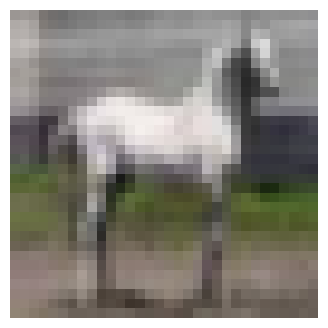

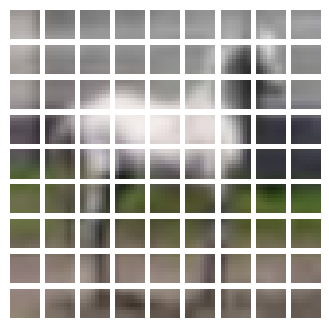

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [215]:

#   def get_config(self):
#     return {**super().config(), 'n': self.n, 'num_patches': self.num_patches, 
#             'num_patches_per_path': self.num_patches_per_path, 'intersection': self.intersection}

Added SplitPathways to custom layers


In [149]:

#   def get_config(self):
#     return {**super().config(),
#             'dense': self.dense,
#             'dropout': self.dropout,
#             'depth': self.depth}

Added MLP to custom layers


In [150]:

    
#     def get_config(self):
#         return {**super().config(), 
#                 'ln1': self.ln1,
#                 'mh_attn': self.mh_attn,
#                 'add1': self.add1,
#                 'ln2': self.ln2,
                

Added ViTBlock to custom layers


In [151]:
# def koleo_regularizer(embedding):
#   dist = tf.norm(embedding[None] - embedding[:, None], axis=2)
#   dist = tf.where(tf.eye(tf.shape(dist)[0])[..., None] == 0, dist, tf.fill(tf.shape(dist), tf.reduce_max(dist)))
#   min_dist = tf.reduce_min(dist, axis=1)
#   out = -tf.reduce_mean(tf.math.log(min_dist))
#   tf.print(min_dist, out)
#   return out

Added ViTOutBlock to custom layers


In [153]:


#   def get_config(self):
#     return {**super().get_config(), 'lambda_': float(self.lambda_)}

Added KoLeoRegularizer to custom layers


In [26]:
model_exp = create_model(only_classtoken=True, l2=1)
model_exp.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_4[0][0]']                
                                                                                                  
 model_patch (Patches)          (None, None, 192)    0           ['data_augmentation[3][0]']      
                                                                                                  
 model_patchenc (PatchEncoder)  (None, 82, 64)       17664       ['model_patch[0][0]']            
                                                                                              

In [27]:
model_exp.save("example.h5")

## Compile, train, and evaluate the mode

In [28]:

# def run_experiment(model):
#     optimizer = tfa.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay
#     )

#     model.compile(
#         optimizer=optimizer,
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[
#             keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#             keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
#         ],
#     )

#     checkpoint_filepath = "/tmp/checkpoint"
#     checkpoint_callback = keras.callbacks.ModelCheckpoint(
#         checkpoint_filepath,
#         monitor="val_accuracy",
#         save_best_only=True,
#         save_weights_only=True,
#     )

#     history = model.fit(
#         x=x_train,
#         y=y_train,
#         batch_size=batch_size,
#         epochs=num_epochs,
#         validation_split=0.1,
#         callbacks=[checkpoint_callback],
#     )

#     model.load_weights(checkpoint_filepath)
#     _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#     print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

#     return history


# vit_classifier = create_vit_classifier()
# history = run_experiment(vit_classifier)


Added ContrastiveLoss to custom layers


In [155]:


    # def __call__(self, *args, **kwargs):
    #   return super(ContrastiveLossExpDecay, self).__call__(*args, **kwargs)

Added ContrastiveLossExpDecay to custom layers


Added ContrastiveSoftmaxLoss to custom layers


In [157]:
@serialize


  # def get_config(self):
  #   return {'lambda_': float(self.lambda_)}

Added KoLeoLoss to custom layers


In [167]:
serialize(tf.optimizers.Nadam, 'Custom')

Added Nadam to custom layers


keras.optimizers.nadam.Nadam

In [41]:
def run_experiment(model, classifier=True):
    optimizer = tf.optimizers.Nadam(
        # learning_rate=learning_rate, weight_decay=weight_decay
    )
    serialize(optimizer, 'Custom')

    model.compile(
        optimizer=optimizer,
        loss={
            model.name + '_embedding': ContrastiveSoftmaxLoss(temperature=10, stable=True) if not classifier else lambda *args: 0.,
            # model.name + '_embedding': ContrastiveLossExpDecay(m=1, neg=0.99, pos=.01, tau=1) if not classifier else lambda *args: 0.,
              # model.name + '_embedding': KoLeoLoss(lambda_=0),
              model.name + '_logits': keras.losses.SparseCategoricalCrossentropy(from_logits=True)}, #ContrastiveSoftmaxLoss(eps=20)
        metrics={model.name + '_logits': keras.metrics.SparseCategoricalAccuracy(name="accuracy")}
    )

    # checkpoint_filepath = "/tmp/checkpoint"
    # checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #     checkpoint_filepath,
    #     monitor="val_accuracy",
    #     save_best_only=True,
    #     save_weights_only=True,
    # )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        # callbacks=[ChangeMask()]
        # callbacks=[checkpoint_callback],
    )

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


CLASSIFIER = False

model = create_model(name='cifar10_model', only_classtoken=True, koleo_lambda=0, n=2, d=0.2, intersection=True, classifier=CLASSIFIER, l2=.0001)
history = run_experiment(model, classifier=CLASSIFIER)


Epoch 1/60
352/352 [==============================] - 223s 588ms/step - loss: 2.8104 - cifar10_model_embedding_loss: 0.5947 - cifar10_model_logits_loss: 2.1615 - cifar10_model_logits_accuracy: 0.2047 - val_loss: 2.5626 - val_cifar10_model_embedding_loss: 0.4073 - val_cifar10_model_logits_loss: 2.1061 - val_cifar10_model_logits_accuracy: 0.2284
Epoch 2/60
352/352 [==============================] - 207s 587ms/step - loss: 2.6258 - cifar10_model_embedding_loss: 0.4365 - cifar10_model_logits_loss: 2.1395 - cifar10_model_logits_accuracy: 0.2194 - val_loss: 2.4869 - val_cifar10_model_embedding_loss: 0.3590 - val_cifar10_model_logits_loss: 2.0800 - val_cifar10_model_logits_accuracy: 0.2406
Epoch 3/60
352/352 [==============================] - 209s 593ms/step - loss: 2.5860 - cifar10_model_embedding_loss: 0.3942 - cifar10_model_logits_loss: 2.1438 - cifar10_model_logits_accuracy: 0.2209 - val_loss: 2.5645 - val_cifar10_model_embedding_loss: 0.3485 - val_cifar10_model_logits_loss: 2.1693 - val_

Epoch 25/60
352/352 [==============================] - 204s 578ms/step - loss: 2.3244 - cifar10_model_embedding_loss: 0.1981 - cifar10_model_logits_loss: 2.0887 - cifar10_model_logits_accuracy: 0.2653 - val_loss: 2.2690 - val_cifar10_model_embedding_loss: 0.1478 - val_cifar10_model_logits_loss: 2.0841 - val_cifar10_model_logits_accuracy: 0.2742
Epoch 26/60
352/352 [==============================] - 205s 581ms/step - loss: 2.3203 - cifar10_model_embedding_loss: 0.1988 - cifar10_model_logits_loss: 2.0841 - cifar10_model_logits_accuracy: 0.2632 - val_loss: 2.2552 - val_cifar10_model_embedding_loss: 0.1487 - val_cifar10_model_logits_loss: 2.0687 - val_cifar10_model_logits_accuracy: 0.2708
Epoch 27/60
352/352 [==============================] - 211s 599ms/step - loss: 2.3420 - cifar10_model_embedding_loss: 0.2028 - cifar10_model_logits_loss: 2.1015 - cifar10_model_logits_accuracy: 0.2616 - val_loss: 2.2923 - val_cifar10_model_embedding_loss: 0.1596 - val_cifar10_model_logits_loss: 2.0988 - v

Epoch 49/60
352/352 [==============================] - 210s 597ms/step - loss: 2.2189 - cifar10_model_embedding_loss: 0.1333 - cifar10_model_logits_loss: 2.0498 - cifar10_model_logits_accuracy: 0.2784 - val_loss: 2.1397 - val_cifar10_model_embedding_loss: 0.0892 - val_cifar10_model_logits_loss: 2.0172 - val_cifar10_model_logits_accuracy: 0.2914
Epoch 50/60
352/352 [==============================] - 213s 604ms/step - loss: 2.2349 - cifar10_model_embedding_loss: 0.1377 - cifar10_model_logits_loss: 2.0612 - cifar10_model_logits_accuracy: 0.2727 - val_loss: 2.1560 - val_cifar10_model_embedding_loss: 0.0967 - val_cifar10_model_logits_loss: 2.0253 - val_cifar10_model_logits_accuracy: 0.2896
Epoch 51/60
352/352 [==============================] - 210s 596ms/step - loss: 2.2387 - cifar10_model_embedding_loss: 0.1289 - cifar10_model_logits_loss: 2.0741 - cifar10_model_logits_accuracy: 0.2717 - val_loss: 2.1974 - val_cifar10_model_embedding_loss: 0.0965 - val_cifar10_model_logits_loss: 2.0673 - v

In [216]:
from datetime import date
model_name = 'models/' + model.name + str(date.today()) + '.keras'
model.save(model_name)

In [217]:
def load_model(model_name):
    with keras.saving.custom_object_scope(keras.saving.get_custom_objects()):
        reconstructed_model = tf.keras.models.load_model(model_name)
    return reconstructed_model

In [218]:
# custom_objects = {"Patches": Patches, "ViTOutBlock": ViTOutBlock, "PatchEncoder": PatchEncoder, 
#                   "SplitPathways": SplitPathways, "ViTBlock": ViTBlock, "L2": tf.keras.regularizers.L2,
#                   "ContrastiveSoftmaxLoss": ContrastiveSoftmaxLoss,
#                  }


loaded_model = load_model(model_name)

In [191]:
loaded_model.fit(x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=1,
    validation_split=0.1,)

176/352 [==============>...............] - ETA: 1:43 - loss: 2.3197 - cifar10_model_embedding_loss: 0.1796 - cifar10_model_logits_loss: 2.1191 - cifar10_model_logits_accuracy: 0.2435

KeyboardInterrupt: 

In [224]:
out1 = model.predict(data)
out2 = loaded_model.predict(data)
out3 = loaded_model.predict(data)

32/32 [==============================] - 1s 30ms/step


In [225]:
(np.abs(out2[0] - out3[0]) < 1e-5).all()

False

In [227]:
out3[0][0]

array([[ 6.61240697e-01,  7.17211962e-01],
       [-6.07838511e-01, -2.95009743e-02],
       [ 5.33237040e-01,  6.06385767e-01],
       [ 2.10551888e-01, -8.56206775e-01],
       [-2.13121474e-01, -1.17185645e-01],
       [ 7.73780465e-01,  7.34242380e-01],
       [-5.23261130e-01, -5.49519360e-01],
       [-2.46685123e+00, -1.17644954e+00],
       [-1.28429443e-01, -2.32411981e-01],
       [-3.93877059e-01, -1.68241084e-01],
       [-5.04436970e-01, -5.15387177e-01],
       [-6.46441102e-01, -6.64476991e-01],
       [ 4.76128370e-01,  9.54944372e-01],
       [-1.94745827e+00, -1.96567547e+00],
       [-3.65800485e-02,  6.08741760e-01],
       [-2.01612338e-01, -3.38300228e-01],
       [-1.24920869e+00, -9.74026203e-01],
       [-1.19057572e+00, -9.70742762e-01],
       [-4.39035267e-01,  5.08678630e-02],
       [ 6.16407156e-01,  6.90815926e-01],
       [-5.75915337e-01, -5.00379026e-01],
       [-7.88680911e-01, -6.59884810e-01],
       [-3.74506623e-01,  3.86533588e-02],
       [ 5.

In [205]:
for i in range(len(model.layers)):
    print(np.isclose(model.get_weights()[i], loaded_model.get_weights()[i]).all())

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [203]:
data = x_test[:1000]

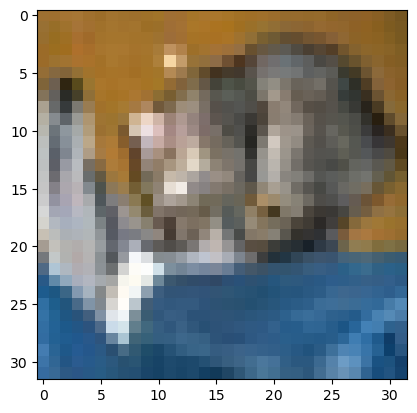

In [232]:
plt.imshow(data[0])

In [256]:
import os
import numpy as np
import random
def set_seed(s):
   os.environ['PYTHONHASHSEED']=str(s)
   tf.random.set_seed(s)
   np.random.seed(s)
   random.seed(s)

In [263]:
for _ in range(2):
    set_seed(0)
    embd1 = loaded_model.predict(data[:2])[0][:, None, ..., 0]
    set_seed(10)
    embd2 = loaded_model.predict(data[:2])[0][None, ..., 0]

    print(np.abs(embd1 - embd2).mean(axis=-1))

1/1 [==============================] - 0s 482ms/step
[[0.       0.961592]
 [0.961592 0.      ]]
1/1 [==============================] - 0s 438ms/step
[[0.       0.961592]
 [0.961592 0.      ]]


In [231]:
np.testing.assert_allclose(
    loaded_model.predict(data[:1])[0], loaded_model.predict(data[:1])[0]
)

1/1 [==============================] - 0s 56ms/step


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 512 / 512 (100%)
Max absolute difference: 1.9433179
Max relative difference: 187.40877
 x: array([[[ 1.256383,  0.977669],
        [ 0.490277, -0.181517],
        [ 0.461135,  0.886034],...
 y: array([[[ 9.308445e-01,  6.017452e-01],
        [ 6.128984e-02, -2.913372e-01],
        [ 6.956784e-01,  4.309582e-01],...

In [122]:
keras.saving.get_custom_objects().clear()

In [121]:
keras.utils.custom_object_scope

keras.saving.object_registration.CustomObjectScope

In [126]:
tf.keras.models.load_model(model_name)

ValueError: Unknown layer: 'Patches'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [25]:
history2 = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    # callbacks=[ChangeMask()]
    # callbacks=[checkpoint_callback],
)

Epoch 1/60
352/352 [==============================] - 235s 666ms/step - loss: 2.1838 - cifar10_model_embedding_loss: 0.1180 - cifar10_model_logits_loss: 2.0312 - cifar10_model_logits_accuracy: 0.2863 - val_loss: 2.1066 - val_cifar10_model_embedding_loss: 0.0801 - val_cifar10_model_logits_loss: 1.9940 - val_cifar10_model_logits_accuracy: 0.3030
Epoch 2/60
352/352 [==============================] - 230s 654ms/step - loss: 2.2073 - cifar10_model_embedding_loss: 0.1193 - cifar10_model_logits_loss: 2.0534 - cifar10_model_logits_accuracy: 0.2771 - val_loss: 2.1334 - val_cifar10_model_embedding_loss: 0.0722 - val_cifar10_model_logits_loss: 2.0277 - val_cifar10_model_logits_accuracy: 0.2740
Epoch 3/60
352/352 [==============================] - 217s 616ms/step - loss: 2.1803 - cifar10_model_embedding_loss: 0.1168 - cifar10_model_logits_loss: 2.0290 - cifar10_model_logits_accuracy: 0.2844 - val_loss: 2.0965 - val_cifar10_model_embedding_loss: 0.0865 - val_cifar10_model_logits_loss: 1.9758 - val_

Epoch 25/60
352/352 [==============================] - 218s 619ms/step - loss: 2.1417 - cifar10_model_embedding_loss: 0.0831 - cifar10_model_logits_loss: 2.0257 - cifar10_model_logits_accuracy: 0.2900 - val_loss: 2.0630 - val_cifar10_model_embedding_loss: 0.0511 - val_cifar10_model_logits_loss: 1.9799 - val_cifar10_model_logits_accuracy: 0.3056
Epoch 26/60
352/352 [==============================] - 217s 617ms/step - loss: 2.1386 - cifar10_model_embedding_loss: 0.0834 - cifar10_model_logits_loss: 2.0222 - cifar10_model_logits_accuracy: 0.2931 - val_loss: 2.0820 - val_cifar10_model_embedding_loss: 0.0620 - val_cifar10_model_logits_loss: 1.9886 - val_cifar10_model_logits_accuracy: 0.3008
Epoch 27/60
352/352 [==============================] - 219s 623ms/step - loss: 2.1262 - cifar10_model_embedding_loss: 0.0845 - cifar10_model_logits_loss: 2.0087 - cifar10_model_logits_accuracy: 0.2966 - val_loss: 2.0595 - val_cifar10_model_embedding_loss: 0.0458 - val_cifar10_model_logits_loss: 1.9816 - v

KeyboardInterrupt: 

In [ ]:
history3 = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=30,
    validation_split=0.1,
    # callbacks=[ChangeMask()]
    # callbacks=[checkpoint_callback],
)

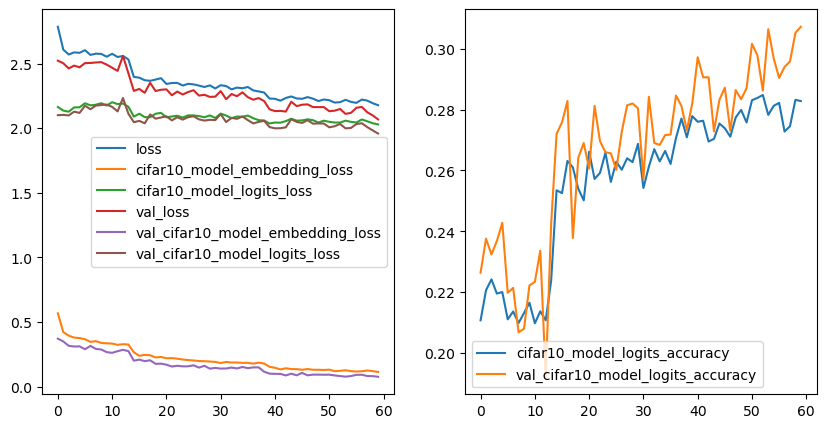

In [26]:
plt.figure(figsize=(10, 5))
for i in range(2):
  plt.subplot(1,2,i+1)
  for l in history.history:
    if i ^ ('loss' in l):
      plt.plot(history.history[l], label=l)
  plt.legend()

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(2):
  plt.subplot(1,2,i+1)
  for l in history.history:
    if i ^ ('loss' in l):
      plt.plot(history2.history[l], label=l)
  plt.legend()

In [27]:
CIFAR10_LABELS = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

In [28]:
def scatter(*args, ax=None, labels=None, title='Classes', **kwargs):
  sc = ax.scatter(*args, **kwargs)
  if labels is not None and isinstance(labels, np.ndarray) and len(labels) > 1:
    assert ax is not None
    ax.add_artist(ax.legend(sc.legend_elements()[0], labels,
                            title=title))
  return sc

In [30]:
X_TRAIN_PCA = PCA(2).fit(x_train.reshape(len(x_train), -1))

In [31]:
def scatterplot_model(model, x, y, labels_to_take=None, subclass=True, pca=X_TRAIN_PCA, train_pca=False, pcs=2):
  if labels_to_take is None:
    labels_to_take = np.unique(y)
  if train_pca:
    mask_train = (y_train == labels_to_take[None]).any(axis=-1)
    pca = PCA(pcs).fit(x_train[mask_train].reshape(mask_train.sum(), -1))

  mask = (y == labels_to_take[None]).any(axis=-1)
  embd = model.predict(x[mask])[0]
  if embd.shape[1] != 2:
    embd = np.stack([PCA(pcs).fit_transform(embd[..., i]) for i in range(embd.shape[-1])], axis=-1)

  # plt.axis("equal")

  subclasses = True
  fig = plt.figure(figsize=(20, 4))
  for i in range(embd.shape[-1]):
    ax = fig.add_subplot(1,embd.shape[-1]+1, i+2, projection='3d' if pcs==3 else None)
    plt.title(f"embedding {i}")
    scatter(*np.split(embd[..., i], pcs, axis=1), c=y[mask] if subclasses else np.floor(y / 5),
            cmap=CMAP, alpha=0.3, ax=ax, labels=CIFAR10_LABELS[labels_to_take])
  ax = fig.add_subplot(1,embd.shape[-1] + 1, 1, projection='3d' if pcs==3 else None)
  plt.title("PCA")
  pca_embd = pca.transform(x[mask].reshape(mask.sum(), -1))
  scatter(*np.split(pca_embd, pcs, axis=1), c=y[mask] if subclasses else np.floor(y[mask] / 5),
              cmap=CMAP, alpha=0.3, ax=ax, labels=CIFAR10_LABELS[labels_to_take])
  plt.tight_layout()
  plt.show()

94/94 [==============================] - 4s 31ms/step


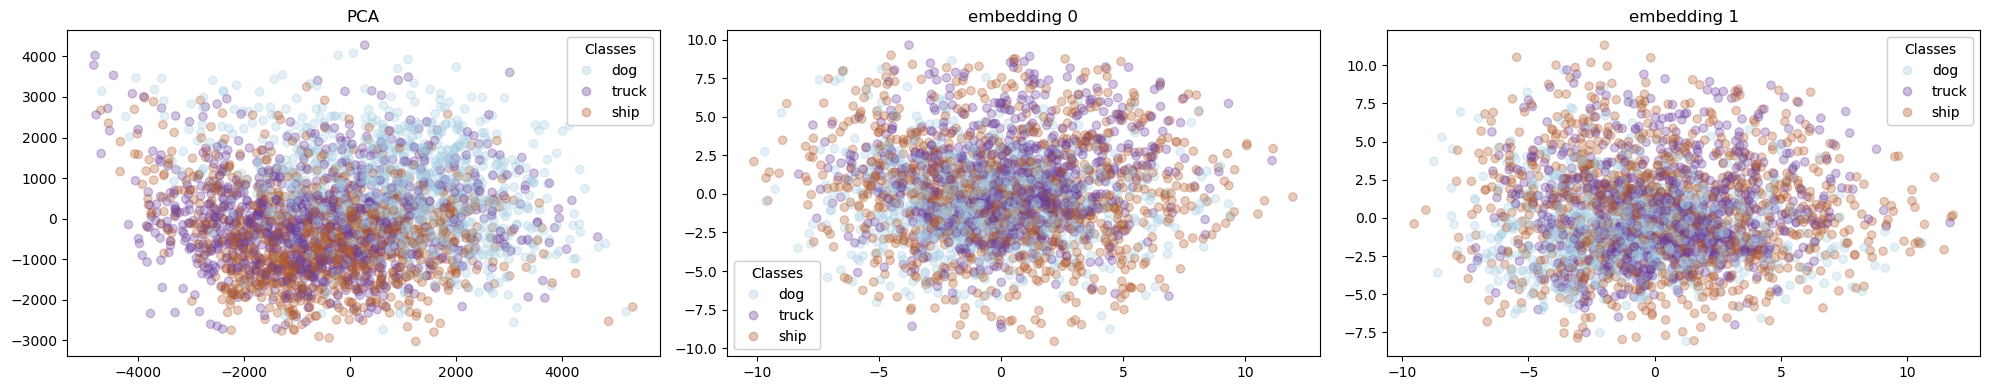

In [32]:
scatterplot_model(model, x_test, y_test, labels_to_take=np.random.permutation(10)[:3], train_pca=True, pcs=2)

In [33]:
pca = PCA(output_dim).fit(model.predict(x_test)[0][..., 0])

313/313 [==============================] - 10s 31ms/step


In [34]:
embd_test = model.predict(x_test)[0][..., 0]

313/313 [==============================] - 11s 35ms/step


In [35]:
np.linalg.norm(embd_test, axis=-1).mean()

13.039561

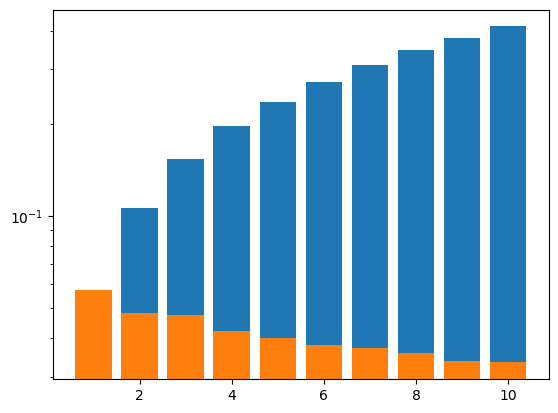

In [36]:
plt.figure()
plt.bar(np.arange(1,11), pca.explained_variance_ratio_.cumsum()[:10])
plt.bar(np.arange(1,11), pca.explained_variance_ratio_[:10])
plt.yscale("log")

313/313 [==============================] - 11s 34ms/step


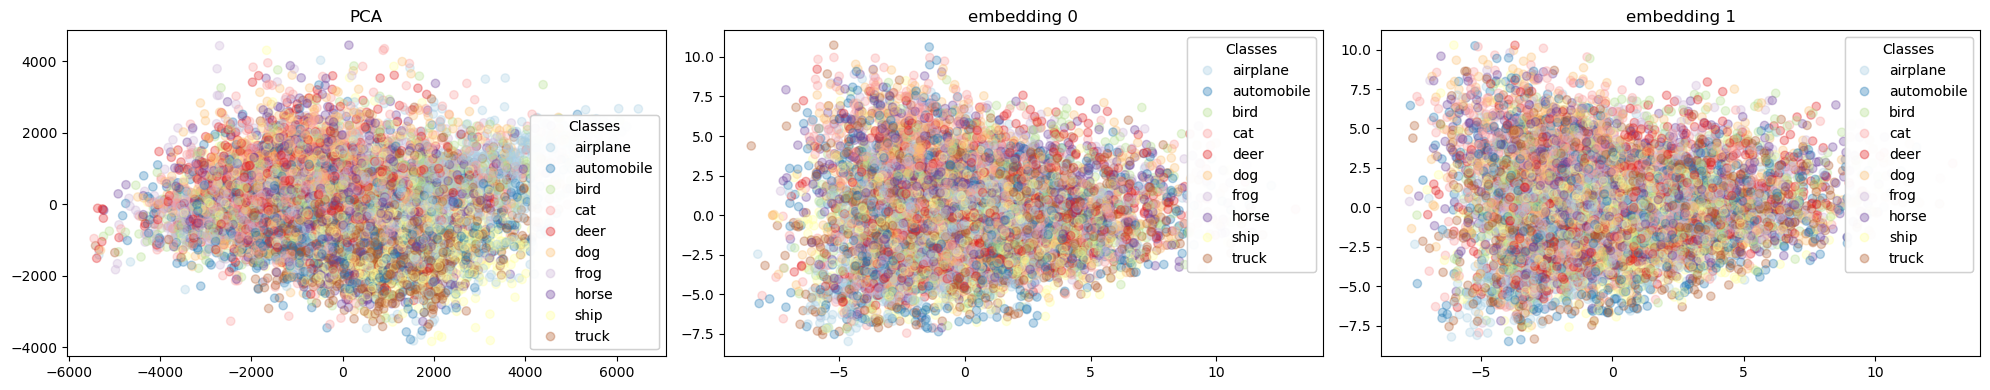

In [37]:
scatterplot_model(model, x_test, y_test)

In [38]:
def linear_head_eval(m=lambda x: x.reshape(x.shape[0], -1), pca=False, svm=True):
    if pca:
      pca = PCA(pca).fit(x_train.reshape(x_train.shape[0], -1))
      m = lambda x: pca.transform(x.reshape(x.shape[0], -1))
    train_embd = m(x_train)
    if svm:
      from sklearn.svm import SVC
      model = SVC(kernel='linear', max_iter=int(1e7))
    else:
      from sklearn.linear_model import LogisticRegression
      model = LogisticRegression()
    model.fit(train_embd, y_train.flatten())

    print(f"Train acc: {model.score(train_embd, y_train.flatten()):.5f}; Test acc: {model.score(m(x_test), y_test.flatten()):.5f}")

In [ ]:
# linear_head_eval()

In [ ]:
linear_head_eval(pca=output_dim)

In [50]:
linear_head_eval(lambda x: model.predict(x)[0][..., 0])

  86/1563 [>.............................] - ETA: 42s

KeyboardInterrupt: 

In [40]:
!ls

Copy_of_image_classification_with_vision_transformer.ipynb


In [51]:
model.save("model.h5")

NotImplementedError: 
Layer Identity was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [60]:
model.layers[-7].activity_regularizer.get_config()

{'l2': 9.999999747378752e-05}

In [ ]:
# np.random.seed(4)

# ds = (x_test, y_test)
# # labels_to_take = np.arange(75,80)

# for lbl1 in range(num_classes-1):
#   for lbl2 in range(lbl1+1, num_classes):
#       labels_to_take = np.array([lbl1, lbl2]) #np.random.permutation(num_classes)[:2]
#       scatterplot_model(model, ds[0], ds[1], labels_to_take, train_pca=True)

In [ ]:
# inds = [np.random.choice(np.where(ds[1][mask] == lbl)[0]) for lbl in labels_to_take]
# plt.figure(figsize=(20, 4))
# ax = plt.subplot(1,len(labels_to_take)+1, 1)
# scatter(embd[inds, 0, 0], embd[inds, 1, 0],
#         c=labels_to_take, labels=CIFAR10_LABELS[labels_to_take], ax=ax, cmap=CMAP)
# for i in range(len(labels_to_take)):
#   plt.subplot(1, len(labels_to_take)+1, i+2)
#   plt.title(CIFAR10_LABELS[labels_to_take[i]])
#   plt.imshow(ds[0][mask][inds[i]])
#   plt.xticks([])
#   plt.yticks([])

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions.
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices,
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.

In [ ]:
[l.name for l in model.layers]